In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Power")

/tmp/ipykernel_1417108/4216975266.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


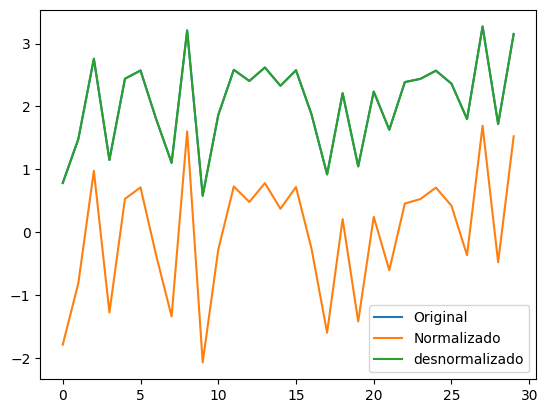

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-07-31 03:07:45.875998: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 03:07:45.930998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 03:07:45.931029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 03:07:45.932038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 03:07:45.937492: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 03:07:45.937982: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-07-31 03:07:46.900333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, _df, _df_1000,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(_df=df_virtual_norm,
                _df_1000=df_1000_norm,
                run_times=50, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 11 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 14 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 19 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 20 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 21 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 26 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 28 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 33 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 35 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 37 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_28,0.627789,0.485226,0.295385,-0.599320,-0.368253,0.059925,0.305592,0.036214,0.254505,0.145360,0.087292,0.244796,0.224560,0.246762,135.629327,319.987651
model_1_0_27,0.630793,0.484956,0.289893,-0.568665,-0.346623,0.059441,0.305753,0.036496,0.249627,0.143062,0.087470,0.243806,0.230819,0.245764,135.645535,320.003858
model_1_0_29,0.578981,0.477053,0.150292,-0.906557,-0.633456,0.067783,0.310444,0.043671,0.303397,0.173534,0.088152,0.260351,0.122877,0.262442,135.382895,319.741219
model_1_0_30,0.540561,0.474747,0.005243,-1.149486,-0.850484,0.073968,0.311813,0.051126,0.342055,0.196590,0.088493,0.271971,0.042836,0.274156,135.208238,319.566562
model_1_0_26,0.663671,0.474454,0.208813,-0.282034,-0.151562,0.054148,0.311987,0.040663,0.204015,0.122339,0.086370,0.232697,0.299316,0.234566,135.832073,320.190397
model_1_0_31,0.497609,0.472053,-0.124105,-1.401447,-1.070479,0.080884,0.313412,0.057774,0.382151,0.219962,0.089593,0.284400,-0.046649,0.286685,135.029490,319.387814
model_1_0_32,0.469620,0.465741,-0.296512,-1.550059,-1.223485,0.085390,0.317159,0.066634,0.405800,0.236217,0.089452,0.292215,-0.104959,0.294562,134.921062,319.279386
model_1_0_25,0.676286,0.457988,0.117426,-0.129973,-0.059781,0.052117,0.321762,0.045360,0.179816,0.112588,0.087262,0.228292,0.325595,0.230125,135.908528,320.266852
model_1_0_33,0.454363,0.454752,-0.640506,-1.576913,-1.326806,0.087846,0.323683,0.084314,0.410073,0.247194,0.088442,0.296388,-0.136744,0.298769,134.864341,319.222665
model_1_0_24,0.699997,0.443030,0.188836,0.041568,0.085969,0.048300,0.330641,0.041690,0.152519,0.097104,0.086270,0.219772,0.374994,0.221537,136.060666,320.418990


DataFrame salvo em ../results/metrics_1_0


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 13 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 14 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 17 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 19 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 20 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 21 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 23 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 25 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 28 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 29 ++++++++++++++++++


Stopped at epoch:  26
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 30 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 31 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 32 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 34 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 39 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 40 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 41 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 42 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 43 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 44 ++++++++++++++++++

Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 45 ++++++++++++++++++


Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 46 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 47 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 49 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 50 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_8,0.430317,0.460530,0.606730,0.663832,0.632327,0.091717,0.320253,0.047155,0.032345,0.039750,0.085155,0.302849,-0.186840,0.305281,134.778089,319.136413
model_1_1_7,0.422839,0.460019,0.624895,0.663056,0.642055,0.092921,0.320556,0.044977,0.032420,0.038698,0.085218,0.304830,-0.202419,0.307278,134.752007,319.110331
model_1_1_6,0.309591,0.458737,0.542770,0.528516,0.536644,0.111154,0.321317,0.054824,0.045365,0.050094,0.097136,0.333397,-0.438352,0.336075,134.393681,318.752005
model_1_1_9,0.448783,0.446805,0.482869,0.596698,0.533768,0.088744,0.328401,0.062006,0.038804,0.050405,0.093092,0.297900,-0.148368,0.300293,134.843993,319.202317
model_1_1_11,0.463103,0.446709,0.479129,0.570894,0.520211,0.086439,0.328457,0.062455,0.041287,0.051871,0.093058,0.294005,-0.118536,0.296366,134.896635,319.254959
model_1_1_5,0.233810,0.446291,0.528684,0.495954,0.514344,0.123354,0.328705,0.056513,0.048498,0.052505,0.099593,0.351218,-0.596228,0.354039,134.185390,318.543714
model_1_1_10,0.450605,0.445676,0.467480,0.588634,0.521645,0.088451,0.329071,0.063852,0.039580,0.051716,0.093761,0.297407,-0.144573,0.299796,134.850614,319.208938
model_1_1_4,0.206667,0.441115,0.523661,0.486314,0.507269,0.127724,0.331779,0.057115,0.049425,0.053270,0.100660,0.357385,-0.652777,0.360256,134.115764,318.474088
model_1_1_12,0.477039,0.440767,0.437902,0.528175,0.478340,0.084195,0.331985,0.067398,0.045398,0.056398,0.094117,0.290164,-0.089502,0.292495,134.949237,319.307561
model_1_1_3,0.191217,0.438249,0.518703,0.476423,0.500118,0.130212,0.333480,0.057710,0.050377,0.054043,0.101466,0.360848,-0.684965,0.363747,134.077188,318.435512


DataFrame salvo em ../results/metrics_1_1


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  34
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 11 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 12 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 13 ++++++++++++++++++


Stopped at epoch:  53
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 14 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 15 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 16 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 17 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 18 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 19 ++++++++++++++++++


Stopped at epoch:  32
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 20 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 21 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 23 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 24 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 25 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 26 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 27 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 29 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 30 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 31 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 33 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 35 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 36 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 39 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 41 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 45 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 49 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 50 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_6,0.454952,0.190139,-0.511175,0.661888,0.066583,0.087751,0.480768,0.294526,0.063947,0.179236,0.097418,0.296228,-0.135516,0.298607,134.866503,319.224827
model_1_2_9,-0.018227,0.186434,-3.297096,0.637554,-1.359229,0.163931,0.482968,0.837498,0.068549,0.453024,0.114723,0.404884,-1.121305,0.408137,133.616614,317.974938
model_1_2_10,0.217734,0.186088,-2.137151,0.602173,-0.787993,0.125942,0.483173,0.611426,0.075241,0.343334,0.106905,0.354884,-0.629721,0.357734,134.143860,318.502184
model_1_2_7,-0.003214,0.180078,-3.190054,0.638879,-1.304254,0.161514,0.486741,0.816635,0.068299,0.442467,0.114557,0.401888,-1.090028,0.405117,133.646322,318.004646
model_1_2_8,-0.021932,0.179363,-3.302805,0.636784,-1.362506,0.164528,0.487165,0.838610,0.068695,0.453653,0.114946,0.405621,-1.129026,0.408879,133.609349,317.967673
model_1_2_11,0.085968,0.162698,-3.032614,0.577516,-1.254575,0.147156,0.497058,0.785950,0.079905,0.432928,0.106692,0.383610,-0.904234,0.386691,133.832518,318.190842
model_1_2_15,-0.582068,0.151901,-6.948036,0.513518,-3.273131,0.254708,0.503468,1.549060,0.092009,0.820534,0.110178,0.504686,-2.295975,0.508740,132.735274,317.093597
model_1_2_14,-0.568865,0.151100,-6.868836,0.521800,-3.228859,0.252583,0.503944,1.533624,0.090442,0.812033,0.110782,0.502576,-2.268470,0.506613,132.752034,317.110358
model_1_2_13,-0.560311,0.150660,-6.809986,0.535949,-3.192025,0.251205,0.504205,1.522154,0.087766,0.804960,0.112064,0.501204,-2.250647,0.505230,132.762969,317.121293
model_1_2_16,-0.620836,0.149835,-7.144209,0.493091,-3.382746,0.260950,0.504695,1.587294,0.095872,0.841583,0.109744,0.510832,-2.376742,0.514936,132.686855,317.045179


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 11 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 12 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 14 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 15 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 18 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_3] | 19 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 20 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 21 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 22 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 23 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 24 ++++++++++++++++++


Stopped at epoch:  38
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 27 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 28 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 30 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 31 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 1s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_3] | 36 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 37 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 40 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 41 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 43 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 46 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 48 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_18,0.691378,0.297439,0.592061,0.291212,0.463188,0.049687,0.417071,0.072468,0.110508,0.091488,0.082200,0.222906,0.357037,0.224697,136.004012,320.362336
model_1_3_35,0.791241,0.295790,0.480121,0.409669,0.459032,0.033610,0.418049,0.092353,0.092039,0.092196,0.062747,0.183329,0.565085,0.184802,136.785889,321.144212
model_1_3_17,0.691881,0.295200,0.599782,0.296422,0.469595,0.049606,0.418399,0.071096,0.109696,0.090396,0.082162,0.222724,0.358086,0.224513,136.007280,320.365604
model_1_3_19,0.697927,0.293839,0.584761,0.283353,0.455788,0.048633,0.419207,0.073764,0.111733,0.092749,0.080671,0.220529,0.370680,0.222300,136.046909,320.405233
model_1_3_34,0.786120,0.290377,0.470594,0.403594,0.451288,0.034434,0.421263,0.094045,0.092987,0.093516,0.063792,0.185564,0.554417,0.187054,136.737422,321.095746
model_1_3_36,0.806424,0.289111,0.526747,0.413292,0.484988,0.031165,0.422014,0.084070,0.091475,0.087773,0.058690,0.176537,0.596717,0.177955,136.936909,321.295233
model_1_3_37,0.806991,0.288389,0.532362,0.409415,0.486142,0.031074,0.422443,0.083073,0.092079,0.087576,0.058507,0.176278,0.597898,0.177694,136.942778,321.301102
model_1_3_38,0.808419,0.285648,0.539955,0.398371,0.485048,0.030844,0.424070,0.081724,0.093801,0.087762,0.057284,0.175624,0.600873,0.177035,136.957630,321.315954
model_1_3_16,0.675587,0.276471,0.638801,0.291327,0.487600,0.052230,0.429518,0.064165,0.110490,0.087327,0.084211,0.228538,0.324139,0.230374,135.904213,320.262537
model_1_3_21,0.694059,0.275109,0.585821,0.211133,0.423306,0.049256,0.430327,0.073576,0.122993,0.098285,0.081608,0.221936,0.362623,0.223719,136.021467,320.379791


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 87ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 1s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 11 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 13 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 14 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 15 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 16 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 17 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 19 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 20 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 21 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 22 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 23 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 24 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 25 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 27 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 28 ++++++++++++++++++


Stopped at epoch:  31
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 29 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 30 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 31 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 32 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 33 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 34 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 35 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 36 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 37 ++++++++++++++++++


Stopped at epoch:  26
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 38 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 39 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 40 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 41 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 43 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 44 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 45 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 47 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 49 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 50 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_2,0.786092,0.229080,0.324100,0.635518,0.558005,0.034439,0.457651,0.058060,0.094290,0.076175,0.065167,0.185576,0.554359,0.187067,136.737159,321.095483
model_1_4_4,0.781809,0.222916,0.298692,0.625011,0.543787,0.035128,0.461311,0.060243,0.097008,0.078626,0.065839,0.187425,0.545436,0.188930,136.697510,321.055834
model_1_4_3,0.783005,0.222597,0.306997,0.628433,0.548425,0.034936,0.461500,0.059529,0.096123,0.077826,0.065725,0.186911,0.547926,0.188412,136.708498,321.066822
model_1_4_5,0.780467,0.222400,0.281536,0.624828,0.539374,0.035344,0.461617,0.061716,0.097056,0.079386,0.065905,0.188000,0.542640,0.189510,136.685247,321.043571
model_1_4_0,0.801727,0.221950,0.420427,0.710510,0.638293,0.031921,0.461884,0.049786,0.074890,0.062338,0.057786,0.178666,0.586930,0.180101,136.888956,321.247280
model_1_4_6,0.770834,0.221935,0.222504,0.604374,0.509311,0.036895,0.461893,0.066787,0.102347,0.084567,0.068821,0.192081,0.522571,0.193624,136.599357,320.957681
model_1_4_7,0.768739,0.215794,0.189938,0.600377,0.498195,0.037232,0.465538,0.069585,0.103381,0.086483,0.069077,0.192957,0.518205,0.194507,136.581152,320.939476
model_1_4_1,0.803334,0.214855,0.390954,0.704358,0.626331,0.031663,0.466096,0.052317,0.076482,0.064400,0.059155,0.177940,0.590279,0.179369,136.905234,321.263558
model_1_4_8,0.760953,0.197791,0.131741,0.582789,0.470492,0.038486,0.476226,0.074584,0.107931,0.091257,0.070300,0.196178,0.501986,0.197754,136.514933,320.873257
model_1_4_9,0.748649,0.187510,-0.056217,0.580926,0.422252,0.040467,0.482329,0.090730,0.108413,0.099571,0.070871,0.201163,0.476353,0.202779,136.414552,320.772876


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 11 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 14 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 15 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 16 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 18 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 19 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 21 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 22 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 24 ++++++++++++++++++


Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 25 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 26 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 27 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 28 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 30 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 32 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 33 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 34 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 35 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 37 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 38 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 39 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 40 ++++++++++++++++++


Stopped at epoch:  38
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 41 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 42 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 43 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 46 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 49 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_45,0.617420,0.291188,0.303902,-0.389724,-0.150225,0.061594,0.420781,0.066972,0.253533,0.160252,0.070845,0.248182,0.202959,0.250175,135.574376,319.932700
model_1_5_47,0.611381,0.290699,0.295273,-0.421400,-0.173944,0.062567,0.421072,0.067802,0.259312,0.163557,0.071080,0.250133,0.190376,0.252142,135.543049,319.901373
model_1_5_46,0.611406,0.290681,0.297313,-0.422215,-0.173773,0.062563,0.421083,0.067606,0.259460,0.163533,0.071064,0.250125,0.190428,0.252134,135.543177,319.901501
model_1_5_40,0.637410,0.290574,0.349502,-0.293491,-0.071476,0.058376,0.421146,0.062585,0.235977,0.149281,0.069556,0.241611,0.244605,0.243552,135.681707,320.040031
model_1_5_42,0.617552,0.290331,0.314682,-0.394396,-0.149562,0.061573,0.421290,0.065935,0.254385,0.160160,0.070594,0.248139,0.203234,0.250132,135.575066,319.933390
model_1_5_43,0.617247,0.290164,0.307618,-0.392473,-0.150742,0.061622,0.421389,0.066614,0.254035,0.160325,0.070821,0.248238,0.202598,0.250232,135.573470,319.931794
model_1_5_41,0.626444,0.289875,0.331214,-0.350028,-0.114805,0.060141,0.421561,0.064344,0.246291,0.155318,0.070171,0.245237,0.221759,0.247207,135.622115,319.980439
model_1_5_49,0.609382,0.289761,0.288785,-0.429987,-0.181805,0.062888,0.421629,0.068426,0.260878,0.164652,0.071215,0.250775,0.186213,0.252790,135.532791,319.891115
model_1_5_44,0.616516,0.289703,0.300200,-0.392873,-0.153564,0.061740,0.421663,0.067328,0.254107,0.160718,0.071073,0.248475,0.201076,0.250471,135.569656,319.927980
model_1_5_48,0.610527,0.289518,0.288820,-0.423139,-0.177310,0.062704,0.421773,0.068423,0.259629,0.164026,0.071258,0.250408,0.188597,0.252419,135.538658,319.896982


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 11 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 12 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 14 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 16 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 18 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 19 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 20 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 21 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 22 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 23 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 24 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 25 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 27 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 28 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 29 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 30 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 31 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 32 ++++++++++++++++++


Stopped at epoch: 

 6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 33 ++++++++++++++++++


Stopped at epoch:  31
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 35 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 36 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 38 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 39 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 40 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 41 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 42 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 43 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 44 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 46 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 47 ++++++++++++++++++


Stopped at epoch:  47
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 49 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 50 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_7,0.662388,0.343795,0.432310,-0.259271,0.305431,0.054354,0.389552,0.099919,0.073630,0.086774,0.076234,0.233140,0.296643,0.235013,135.824458,320.182782
model_1_6_6,0.676099,0.343416,0.465764,0.160131,0.427139,0.052147,0.389777,0.094031,0.049107,0.071569,0.073895,0.228357,0.325206,0.230192,135.907373,320.265697
model_1_6_5,0.680670,0.342470,0.500704,0.591885,0.552785,0.051411,0.390338,0.087881,0.023862,0.055872,0.072554,0.226740,0.334730,0.228561,135.935802,320.294126
model_1_6_8,0.650844,0.334323,0.414352,-0.649214,0.201531,0.056213,0.395174,0.103080,0.096429,0.099755,0.077522,0.237093,0.272592,0.238997,135.757212,320.115536
model_1_6_4,0.665075,0.332749,0.512518,0.737498,0.595180,0.053922,0.396109,0.085802,0.015348,0.050575,0.072804,0.232211,0.302240,0.234076,135.840439,320.198762
model_1_6_3,0.637348,0.304513,0.540900,0.882043,0.648998,0.058386,0.412871,0.080806,0.006897,0.043852,0.070382,0.241632,0.244475,0.243573,135.681361,320.039685
model_1_6_2,0.630467,0.300051,0.546046,0.886702,0.653712,0.059494,0.415520,0.079900,0.006625,0.043263,0.070661,0.243913,0.230139,0.245873,135.643769,320.002093
model_1_6_1,0.617109,0.293994,0.544302,0.891208,0.653538,0.061644,0.419115,0.080207,0.006361,0.043284,0.071303,0.248283,0.202310,0.250277,135.572747,319.931071
model_1_6_0,0.612684,0.290666,0.543892,0.894783,0.654086,0.062357,0.421091,0.080280,0.006152,0.043216,0.071411,0.249713,0.193091,0.251719,135.549767,319.908091
model_1_6_9,0.523278,0.216553,0.320871,-3.341268,-0.494278,0.076751,0.465088,0.119534,0.253834,0.186684,0.084043,0.277039,0.006830,0.279265,135.134384,319.492708


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 11 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 12 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 13 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 14 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 17 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 19 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 20 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 21 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 22 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 23 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 26 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 27 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 28 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 29 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 31 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 32 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 34 ++++++++++++++++++


Stopped at epoch:  39
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 35 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 36 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 37 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 38 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 39 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 41 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 42 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 43 ++++++++++++++++++


Stopped at epoch:  32
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 44 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 45 ++++++++++++++++++


Stopped at epoch:  9


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 46 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 48 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 49 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 50 ++++++++++++++++++

Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_23,0.154552,-0.017553,0.438946,-3.234018,-1.840300,0.136115,0.604063,0.050374,0.709914,0.380144,0.093206,0.368937,-0.761350,0.371900,133.988516,318.346840
model_1_7_24,0.159721,-0.020051,0.460893,-3.217185,-1.822400,0.135282,0.605546,0.048403,0.707092,0.377748,0.092522,0.367807,-0.750580,0.370762,134.000783,318.359107
model_1_7_25,0.148007,-0.022284,0.441380,-3.292293,-1.875986,0.137168,0.606872,0.050155,0.719685,0.384920,0.093054,0.370363,-0.774986,0.373337,133.973092,318.331416
model_1_7_26,0.142381,-0.030331,0.440578,-3.331918,-1.901079,0.138074,0.611649,0.050227,0.726329,0.388278,0.093030,0.371583,-0.786705,0.374568,133.959931,318.318255
model_1_7_22,0.163640,-0.044166,0.478909,-3.165533,-1.784000,0.134651,0.619862,0.046786,0.698431,0.372608,0.092968,0.366949,-0.742417,0.369896,134.010132,318.368456
model_1_7_27,0.036339,-0.050420,0.331311,-4.005826,-2.359853,0.155146,0.623574,0.060038,0.839322,0.449680,0.098715,0.393886,-1.007627,0.397050,133.726771,318.085095
model_1_7_30,-0.066347,-0.078758,0.205845,-4.639750,-2.799014,0.171679,0.640398,0.071303,0.945612,0.508457,0.101100,0.414341,-1.221555,0.417669,133.524262,317.882586
model_1_7_19,0.146085,-0.080682,0.516095,-3.226691,-1.809836,0.137478,0.641540,0.043447,0.708686,0.376066,0.093280,0.370780,-0.778989,0.373758,133.968587,318.326910
model_1_7_20,0.146764,-0.081497,0.516735,-3.230422,-1.811958,0.137368,0.642024,0.043390,0.709311,0.376350,0.092680,0.370632,-0.777574,0.373609,133.970178,318.328502
model_1_7_21,0.146592,-0.081961,0.510404,-3.235465,-1.817239,0.137396,0.642299,0.043958,0.710157,0.377057,0.092533,0.370670,-0.777933,0.373647,133.969774,318.328098


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 11 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 13 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 14 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 15 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 16 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 17 ++++++++++++++++++


Stopped at epoch:  28
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 19 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 20 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 22 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 23 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 24 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 27 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 30 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 31 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 34 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 35 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 36 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 37 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 39 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 40 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 41 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 42 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 43 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 46 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 48 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 50 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_35,0.441765,0.263919,-3.257207,0.558940,-0.970382,0.089874,0.436970,0.438162,0.062130,0.250146,0.082233,0.299790,-0.162990,0.302198,134.818689,319.177013
model_1_8_37,0.441084,0.263400,-3.273097,0.560322,-0.976057,0.089984,0.437278,0.439798,0.061935,0.250867,0.081898,0.299973,-0.164409,0.302383,134.816250,319.174574
model_1_8_36,0.441816,0.263073,-3.266171,0.561888,-0.972381,0.089866,0.437472,0.439085,0.061715,0.250400,0.082028,0.299776,-0.162882,0.302184,134.818874,319.177198
model_1_8_38,0.438830,0.262313,-3.297413,0.558912,-0.986696,0.090347,0.437923,0.442300,0.062134,0.252217,0.081916,0.300577,-0.169105,0.302992,134.808201,319.166525
model_1_8_34,0.453204,0.261277,-3.125371,0.572657,-0.909332,0.088033,0.438538,0.424593,0.060198,0.242396,0.083104,0.296703,-0.139159,0.299086,134.860098,319.218422
model_1_8_39,0.430967,0.260183,-3.381909,0.556896,-1.022066,0.091613,0.439187,0.450997,0.062418,0.256708,0.082107,0.302676,-0.185486,0.305107,134.780372,319.138696
model_1_8_40,0.419875,0.258119,-3.483414,0.535739,-1.074948,0.093398,0.440412,0.461444,0.065398,0.263421,0.082463,0.305612,-0.208595,0.308066,134.741761,319.100085
model_1_8_41,0.418862,0.257817,-3.494403,0.533946,-1.080399,0.093561,0.440592,0.462575,0.065651,0.264113,0.082379,0.305878,-0.210703,0.308335,134.738275,319.096599
model_1_8_42,0.398899,0.257785,-3.691656,0.524523,-1.165584,0.096775,0.440611,0.482877,0.066978,0.274928,0.083122,0.311088,-0.252294,0.313586,134.670723,319.029047
model_1_8_45,0.416543,0.257388,-3.513075,0.508593,-1.102032,0.093935,0.440847,0.464497,0.069222,0.266859,0.081264,0.306488,-0.215536,0.308950,134.730307,319.088631


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  47
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 11 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 12 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 13 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 14 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 15 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 16 ++++++++++++++++++


Stopped at epoch:  28
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 18 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 19 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 21 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 22 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 23 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 26 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 27 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 28 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 30 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 34 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 36 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 37 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 38 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 39 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 42 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 44 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 45 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 46 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 47 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 50 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_10,0.717160,0.365831,0.550129,0.142840,0.344215,0.045536,0.376470,0.056480,0.119521,0.088001,0.079173,0.213392,0.410751,0.215106,136.178489,320.536813
model_1_9_11,0.634628,0.364749,-0.188529,0.149560,0.002166,0.058824,0.377113,0.149217,0.118584,0.133900,0.083757,0.242536,0.238809,0.244484,135.666420,320.024744
model_1_9_35,0.656804,0.364594,-0.027814,-0.033586,-0.017805,0.055254,0.377205,0.129040,0.144121,0.136581,0.076807,0.235061,0.285008,0.236949,135.791646,320.149970
model_1_9_36,0.651411,0.364592,-0.016629,-0.087583,-0.040627,0.056122,0.377206,0.127636,0.151650,0.139643,0.077039,0.236900,0.273773,0.238803,135.760462,320.118786
model_1_9_48,0.652821,0.364539,0.031452,-0.145816,-0.048390,0.055895,0.377237,0.121599,0.159770,0.140685,0.076545,0.236421,0.276710,0.238320,135.768569,320.126893
model_1_9_17,0.660614,0.364386,-0.114352,0.150460,0.037334,0.054640,0.377328,0.139905,0.118458,0.129181,0.079505,0.233752,0.292945,0.235630,135.813972,320.172296
model_1_9_37,0.639111,0.364110,-0.007206,-0.194385,-0.091708,0.058102,0.377492,0.126453,0.166543,0.146498,0.077599,0.241044,0.248148,0.242980,135.691108,320.049432
model_1_9_49,0.653162,0.363989,0.021510,-0.137451,-0.048695,0.055840,0.377564,0.122847,0.158604,0.140726,0.076484,0.236305,0.277420,0.238203,135.770533,320.128857
model_1_9_47,0.650538,0.363898,0.018251,-0.151253,-0.057390,0.056262,0.377618,0.123257,0.160528,0.141892,0.076802,0.237197,0.271955,0.239102,135.755463,320.113787
model_1_9_33,0.663658,0.363513,-0.039968,0.033073,0.011141,0.054150,0.377846,0.130566,0.134826,0.132696,0.076447,0.232702,0.299287,0.234571,135.831990,320.190314


DataFrame salvo em ../results/metrics_1_9
